In this lesson we'll be exploring methods of tabular modeling. Tabular data is represented in a table i.e a spreadsheet with columns and rows. Our goal is to use the data in our columns to predict the value of another column. 


In [71]:
%matplotlib inline



#import sys
#!{sys.executable} -m pip3 install fastbook kaggle waterfallcharts treeinterpreter dtreeviz

import fastbook
fastbook.setup_book()


from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from treeinterpreter import treeinterpreter as ti
from waterfall import *

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

Some information before we start:

Continous variable - Data that can be represented numerically that can be mathematically operated on. We can feed these into our models directly because the mathematical operations we'll do in our model (multiplication, addition, etc.) will make sense straight away.

Categorical variable - Variables that take on a variety of discrete values. These need to be converted to a number before we can use them as input in our model. 

In our recent excercises we've just been training neural networks to solve every problem we've had. 

hewwo, its bubu speaking now. you have 8 days to live. you can extend this time by buying bubu a thai iced tea. >-<

This hasn't been because neural networks are the magical solution to all our problems, although I desperately wish this were the case. It would be so nice if deep learning could fight my demons for me. 

Rather, it's because their flexibility allows them to excel at handling problems related to the unstructured data we've been workign with so far - images, audio, and text. 

When it comes to the structured, tabular data we'll be working with here, we'll make use of decision trees and gradient boosting machines. Simpler, but equally effective modeling techniques.

Decision trees will be our tool of choice for tabular data for a number of reasons. They're typically faster and easier to train, requiring less specialized GPU hardware and hyperparameter tuning than neural networks. Libraries that implement decisions trees also have tools and methods for interpreting these models, such as visualizing which columns were the most important factors in making a prediction. 

Note: there are some instances where a neural network would be better for tabular data - like if one of the columns is unstructured data like a string of text.

Yay, I'm now so excited to use decision trees. In fact why don't I use one to model this feeling. It'll try to predict if I am excited at any given moment or not. The condition it'll split on is "are decision trees involved" and it'll predict "Yes" if so, and "No" if not. Amazing, we already have an 100% accurate model.


In [23]:
creds = '{"username":"alexanderzliu","key":"59b8c0e913b2beb56e71628b918cba51"}'

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path.BASE_PATH = path

from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

(#7) [Path('random_forest_benchmark_test.csv'),Path('Valid.csv'),Path('median_benchmark.csv'),Path('Test.csv'),Path('ValidSolution.csv'),Path('Machine_Appendix.csv'),Path('TrainAndValid.csv')]

After setting up our data we'll read it in and look at some of the columns. Seems like there's a lot of columns for us to parse through


In [24]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

Let's take care of an 'ordinal' column. This is kinda a middle point between our categorical and continous variables where it means our variable is categorical, but the categories have a natural ordering. 

We'll make our 'ProductSize' column values take on the type 'category'. Then we can pass in a list of those categories with a specific order, setting the 'ordered' parameter to True. 


In [25]:
print(f"Product Size levels: {df['ProductSize'].unique()}")
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True)

Product Size levels: [nan 'Medium' 'Small' 'Large / Medium' 'Mini' 'Large' 'Compact']


0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

The Kaggle competition asks uses to use the root mean squared log error (RMSLE) between actual and predicted auction prices as our metric - our statistic informing us of how well our model is performing. Roots, logs and trees; data scientists can't get enough of plants.

We'll take the log of our dependent variable now , the SalePrice, so that we can just use RMSE operations in the future to get our RMSLE.


In [26]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

Below is an illustration of a decision tree. Who knew such a messed-up looking conifer could be so powerful. 

The tree asks a series of binary (yes/no) questions about the data. After each question, the data is split on branching yes/no paths. Eventually, the bottom of the tree (a leaf node) is reached, where that node will have a prediction for data point, which depends on the answers that led to that particular leaf node. 

In this example, we first answer a question about age. This leads to questions about either our diet or excercise habits, depending on our first answer. Then depending on this next answer, we're either labeled fit or unfit.

You're all probably well aware of the category I fall into. As a super sexy data scientist, I am a indeed a fit model that fits models. 

![Decision Tree](decision_tree.PNG)

Outside this toy example, our challenge will be to come up with this series of questions that will split our data into as distinct categories as possible, so that predictions we make are accurate because the conditions we split the data do a good job at discerning it from the other categories of our dependent variable. 

This is how we'll approach the construction process: 

1. Loop through each column of the dataset 
2. For each column, loop through each possible levels (values or categories) of that column
3. Try splitting the data into two groups, based on whether they are greater than or less than that level if it is continous, or if it is a categorical variable, based on whether they are equal to or not equal to that level of that categorical variable.
4. Find the average sale price for each of those two groups, and see how close that is to the actual sale price of each of the items of equipment in that group. We'll essentially create a very simple mini-model where our predictions will be the average sale price of the items that fall into our two groups after splitting. 
5. After looping through all columns and possible levels for each, pick the split point that gave the best predictions using that simple model.
6. We now have two different groups for our data, based on this selected split. Treat each of these as separate datasets, repeat steps 1 - 5 for these new datasets.
7. Continue this process recursively, until you have reached some stopping criterion for each group, e.g. stop splitting a group further when it has only a certain number of items in it.



Let's talk about handling dates. Dates are interesting because they contain a lot of both continuous and categorical data. For example - they tell us how far away another target date is, but also what day of the week, month of the year, or even day of the year (like for important holidays) it is. 

We want to parse out all the data contained in our date, and will use a fastai function to do so - .add_datapart(), by passing in our data column in our train and test sets.


In [27]:
df = add_datepart(df, 'saledate')
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')
' '.join(o for o in df.columns if o.startswith('sale'))

/Users/alexander/anaconda3/envs/.venv-dlb/lib/python3.11/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
/Users/alexander/anaconda3/envs/.venv-dlb/lib/python3.11/site-packages/fastai/tabular/core.py:23: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

Predictions for our test set will be trying to predict the SalePrice for bull dozers sold in the future. To mimic the relationship that the test set will have with the rest of our data (being in the future), we will also separate our training and validation sets in a similar manner. 

We'll make our our training set data from before October 2011, and validation set comprise of sales after that date, so that we validate our model on data from after our training set, which our test set will also be. 

Using np.where() we can get the set of row indices that fulfill our date conditions.

In [28]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

Now let's start processing the rest of our data. We'll make use of the TabularPandas class, which is a wrapper for our dataframe that provides us access to some more convenient functions. 

We'll need to pass in a few things when creating our TabularPandas object. First the 'procs', which will are data processing operations we want applied. 

Categorify - turn columns into numerical category columns. 
FillMissing - fill rows with missing data (na) with the median of that column. 

Then, the continous and categorical variables, which we'll extract using the cont_cat_split() method. 

Finally, our y-label/dependent variable and the training/validation splits. 


In [29]:
procs = [Categorify, FillMissing]
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

Taking a little bit of ac closer look at the 'Categorify' proc, we can see that the values are still represented as strings when we look at them, which is for our convenience in interpreting the data. 


In [30]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


They're actually just stored as numbers where all of the levels in a column are replaced by numbers. The levels aren't indexed in any particular order, unless they ARE ordered as we saw in the ProductSize category. Otherwise, they're just assigned as unique levels are seen from the top to bottom of the data frame. 


In [31]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


With this pre-processing done, let's save our work right now, which will be us pickling our TabularPandas object. YUM I LOVE DILL.


In [32]:
save_pickle(path/'to.pkl',to)

Okay, lets start to actually create a decision tree. We'll use the .train and .valid attributes from our TabularPandas object to split our dataset.


In [33]:
to = load_pickle(path/'to.pkl')
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

Then we'll use the DecisionTreeRegressor class from sklearn (a nice library for non-deep learning machine learning models)

We'll pass in an argument for the maximum leaf nodes it should have, fit it (which will be done through the 7-step method done mentioned above) 

In [34]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

Here we can take a look at the tree. For each node it tells us the condition and value that it branches on (except for the leaf nodes), the squared error, the number of samples contained in that particular node, and the value, which is the average of the samples dependent variable. 


In [35]:
#draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

There are some bulldozers that were somehow made in the year 1000, which is cap because dirt wasn't even invented back then. We'll just make the earliest manufacturing year 1950. 


In [36]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

Let's make a new model. It'll be larger because we aren't specifying any stopping points. As a default, it'll create levels until all the leaves are pure - that is, they only have samples from one level of our dependent variable. 

We'll also create  a funciton for our models root mean squared error. 


In [37]:
m = DecisionTreeRegressor()
m.fit(xs, y);
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

A perfect model. JK it is not my bubu (that's my pet name for my girlfriend - I am pandering to her :D). Our error is 0 on the validation set because we've create a huge tree with pure leaf nodes. The validation set's error is quite a bit higher. 


In [38]:
print(f"Training set RMSE: {m_rmse(m, xs, y)}")
print(f"Validation set RMSE: {m_rmse(m, valid_xs, valid_y)}")

Training set RMSE: 0.0
Validation set RMSE: 0.329981


That's cause our model is vastly overfitted. We can see that there are almost as many leaves as samples. This means that our model won't generalize well to unseen data because it's too specific (re: overfitted).  


In [39]:
m.get_n_leaves(), len(xs)

(324330, 404710)

Let's fix this overfitting a bit. Now we'll stop our tree creation when there are less than 25 samples in a leaf. This should make it generalize more well. 

You can think about this as the model not uncovering patterns or relationships between our independent variables and dependent variable (e.g. newer bulldozers having higher sale prices). Instead our model is essentially memorizing the decision path it needs for a specific sample (e.g. This bulldozers sale price is 12. It has a Drive_System of X, Enclosure of Y, state is ...and so on and so forth for all of our independent variables. The tree is going to split on all of these and create a leaf node with a value of 12). 


In [40]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.243051, 0.309041)

Let's talk about bagging. There are many types of bagging you might be familiar with - sandbagging, carpetbagging, teabagging. But today we're dealing with some pure, unadultered bagging. 

Bagging is basically getting predictions from a bunch of different models and taking the average of those predictions to use as our prediction. It's a specific 'ensembling' approach, where multiple models are used to get your prediction. Here's how we'll bag:

1. Choose a random subset of our data  
2. Train a model using this subset 
3. Repeat steps 1 & 2 a number of times 
4. Make a prediction with all our models and then take the average of each of those model's predictions to use as our prediction

This approach works because by training our models on different sets of the data will produce uncorrelated error for our predictions, which should average out to 0.

Random forests is the technique when you bag with decision trees. Specifically, they not only use a random subset of the data for each tree's training, but also choose from a random subset of the columns when deciding each split for the decision trees, essentially enforcing some variety in the splits of the trees.

Let's start training a random forest of our own. There are some parameters we should go over here. 
- n_estimators: The number of decision trees in our random forest 
- max_samples: the number of samples we should take from our dataset to train each of our decision trees
- max_features: The proportion of total columns to potentiallly split on at each level (.5 means we'll consider half of the columns we have to split on at a given level)
- min_samples_leaf: minimum number of samples a leaf should have 
- n_jobs: CPU-related argument; probably don't need to worry about this too much 


In [41]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

We can see how our error has improved with this random forest as compared to our singular decision tree. A cool thing about random forests is that they aren't super sensitive to hyperparmeter changes, and work pretty well right off the bat with just their default arguments. 


In [42]:
m = rf(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171426, 0.232733)

After plotting our error as a function of the number of decision trees in our forest, we can see the error goes down until tapering out at around 30. 


/Users/alexander/anaconda3/envs/.venv-dlb/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/alexander/anaconda3/envs/.venv-dlb/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/alexander/anaconda3/envs/.venv-dlb/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/alexander/anaconda3/envs/.venv-dlb/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/alexander/anaconda3/envs/.venv-dlb/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/Users/alexander/anaconda3/envs/.venv-dlb/lib/python3.11/site-packages/skle

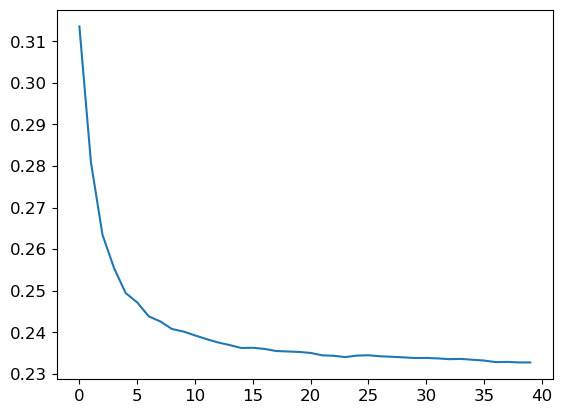

In [43]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

Let's talk about OOBE. This fun little acronym stands for 'out of bag error' - an phrase that's even more fun! This is our error for the rows that weren't part of the random sample used in training our particular decision tree. 

This is lower than our validation error, so there must be something bumping that number up. 


In [44]:
r_mse(m.oob_prediction_, y)

0.211354

Our preds is a stacked array of all of our trees' predictions of all of the auctions. It's got a shape of (40, 7900), which corresponds to 40 rows, one for each of our trees, and over 7000 columns, one for each of the auctions. 

We'll get the standard deviation of our predictions along the 0-index axis, which is between all our trees for a given auction. This value can be interpreted as how much our trees agree on their predictions for a given auction. We can see our the different values of standard deviations from our first 5 auctions how much the models (dis)agree on their predictions.  


In [45]:
preds_std = preds.std(0)
preds_std[:5]

array([0.26048485, 0.12321484, 0.12067137, 0.24954422, 0.13425484])

Not all features are created equal. Some of our columns might be used more than others to determine a split, or will result in a split that partitions the dataset in a significant manner. These will be of particular importance to us in being a more significant indicator of our dependent variable. If only there was some way to the determine the importance of our features. Our feature importance, if you will...

WELL WE'RE IN LUCK! Our random forest object has an attribute that will tell us the importances of our features, aptly named .feature_importances_.

Let's take a look at our most important features.


In [46]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.171413
30,Coupler_System,0.111176
6,ProductSize,0.096954
7,fiProductClassDesc,0.084829
54,ModelID,0.057510
65,saleElapsed,0.051394
32,Hydraulics_Flow,0.048373
3,fiSecondaryDesc,0.047954
31,Grouser_Tracks,0.042956
12,Enclosure,0.042070


The way that importance is calculated, is that all branches of all the decision trees are iterated through. The 'improvement' of the model as a result of that split (usually measured by the gini or impurity reduction) is weighted by the number of samples in that node, and is summed for each feature across all branches of all trees. These sums are then normalized to 1. 


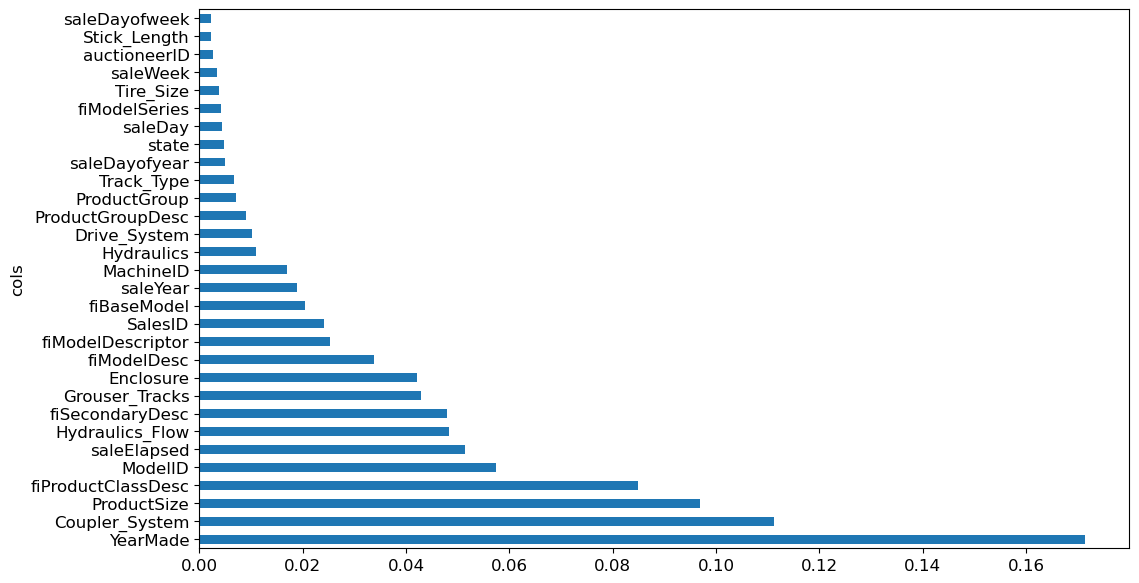

In [47]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Let's focus on just what's important. We'll remove all the columns with a really small feature importance value and train another model on our only important columns. 

We can see that the performance is basically the same as our model trained on the entire dataset, but now the task of scrutinizing is much more manageable with this subset of columns. 

Let's make it a habit of simplying our model when possible as one of the first things we do to try and improve it. 


In [48]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y)
print(f"Important feature training error: {m_rmse(m, xs_imp, y)}, Important feature valid error: {m_rmse(m, valid_xs_imp, valid_y)}")
print(f" All columns: {len(xs.columns)}, Important columns: {len(xs_imp.columns)}")

Important feature training error: 0.181752, Important feature valid error: 0.231166
 All columns: 66, Important columns: 21


Another step we can take to simplying our model (by removing unnecessary columns) is to remove redundant ones. Here's a visualization of the our most similar columns. 

As expected, something like 'saleYear' and 'saleElapsed' are very similar. Even though they might have different values, the model will be able to extract the same insights - how long ago it was sold - from the columns. 


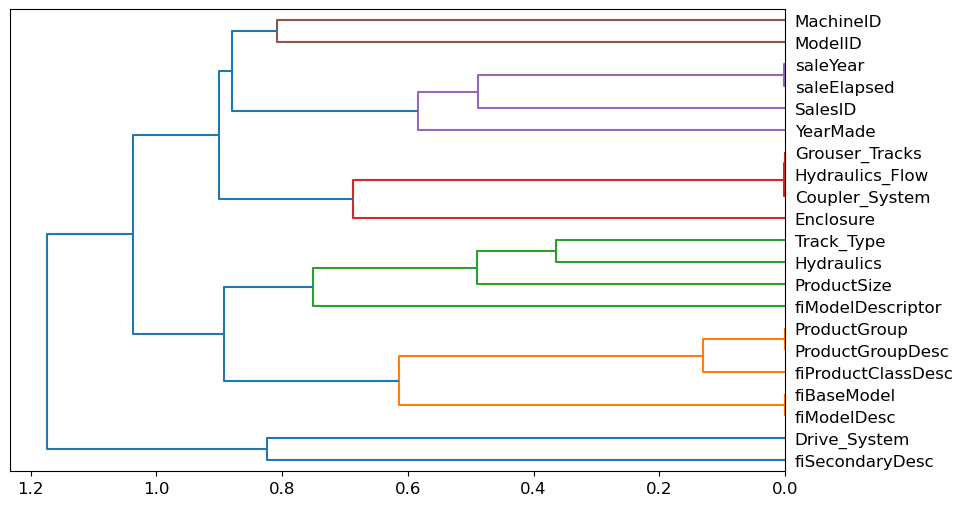

In [49]:
cluster_columns(xs_imp)

Let's experiment to see if dropping columns has any affect on our performance (hint: if we're making a point to illustrate this technique it probably won't). I'm a big fan of dropping things - the beat, some bars, some facts, and columns are no exception. 

This method will give us our OOB score, and the parameters to the model we're training in this function are set up to train it quickly. We can see the baseline OOB error for our model with all important columns below.


In [50]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

get_oob(xs_imp)

0.8755843680559935

Dropping one of each our potentially redudant variables at a time, the OOB error doesn't change much. 


In [51]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8746679612411252,
 'saleElapsed': 0.8702083126422467,
 'ProductGroupDesc': 0.8753608603727971,
 'ProductGroup': 0.8757640492749871,
 'fiModelDesc': 0.8736460335938832,
 'fiBaseModel': 0.8755019013911903,
 'Hydraulics_Flow': 0.8762507093871456,
 'Grouser_Tracks': 0.8765045615261711,
 'Coupler_System': 0.8760192680430767}

Even dropping multiple redundant columns at a time still holds up


In [52]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8733542953468885

Let's create a dataframe with our dropped variables (and save it as a good practice).

As a final check, we'll look at the validation errors from this random forest model training on our dataset with redundancies eliminated. Looks pretty similar to our performance from having the entire dataset, so it looks like we've been able to effectively simplify our model even further. I told you it would all work out.


In [53]:
xs_final = xs_imp.drop(to_drop, axis=1) #create dataframe without dropped columns
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1) #create dataframe without dropped columns
save_pickle(path/'xs_final.pkl', xs_final) #save df
save_pickle(path/'valid_xs_final.pkl', valid_xs_final) #save df
xs_final = load_pickle(path/'xs_final.pkl') #reload df
valid_xs_final = load_pickle(path/'valid_xs_final.pkl') #reload df
m = rf(xs_final, y) #train random forest model
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y) #get validation error

(0.183904, 0.232606)

Now let's talk about 'partial dependence'. These plots try and isolate the effect that a single independent variable has on our dependent variable, without that relationship being affected by changes in our other variables. 

How this will work is we'll take every level of our independent variable (IV) in question (we're looking at 'YearMade' and 'ProductSize' in this example because they are our most important features) and for our entire dataset, replace every value of that independent variable with one of the levels of our IV. Then we'll use our model to make predictions , where all our other features are the same as before, except for our IV which has had all of its values swapped with one of its levels. Then we'll repeat this process for every level in that IV. This will give us predictions where everything is held constant except for the IV we're investigating.

This translates to our working dataset by keeping all the columns the same except 'YearMade'. We'll replace all the values in that column with 1950, make our predictions, take the average, and that'll be our prediction for bulldozers from 1950. Then we'll replace all the values in the column with 1951, and rinse and repeat with making and averaging predictions for all the levels in the 'YearMade' column.

In plotting this, we can see that the year and price have a very strong, positively correlated relationship, as we'd except. The 'ProductSize' doesn't quite have as clean a relationship though, which we'll talk about shortly. 


TypeError: PartialDependenceDisplay.__init__() takes 2 positional arguments but 3 were given

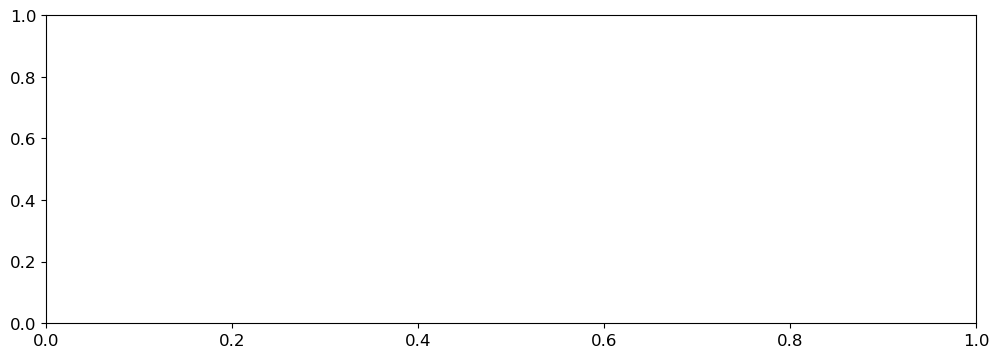

In [59]:
from sklearn.inspection import PartialDependenceDisplay

fig,ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay(m, valid_xs_final, ['YearMade','ProductSize']);

We've seen how much an impact our features have aggregated across our entire dataset, but what if we wanted to drill down into a single row and analyze how our features influenced the prediction for that one data point? 

We can do this with the treeinterpreter library. 

Let's pass in the first 5 rows of our validation set and pass them to our treeinterpreter, along with our model.

The output we'll get from the .predict() method is:
- prediction: self-explanatory (our prediction from our random forest)
- bias: the prediction we'd get just by taking the mean of our dependent variable. This would be equivalent to if our model was just the root of the tree with no branches
- contributions: The increase or decrease in our prediction based on branch split we take on our path to a leaf node a.k.a the change in our prediction caused by the independent variables. Summing this up, and adding it to our bias will equal the prediction. 


In [65]:
row = valid_xs_final.iloc[:5]
prediction,bias,contributions = ti.predict(m, row.values)

Plotting these contributions, we can visualize the impact that each of the independent variables had on our prediction. 


In [72]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

TypeError: 'module' object is not callable

We've covered some pretty effective yet simple ways of improving and interpreting our model. But it's not all sunshine and rainbows when it comes to machine learning. 

Random forests have a pretty large issue when it comes to extrapolating data - that is making predictions for data it hasn't seen before, that we'll illustrate in an example. 

Let's train a model on the first 30 rows of a slightly noisy but mostly linear dataset

In [ ]:
np.random.seed(42)
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape
x_lin[:,None].shape
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

When we try to make a prediction on the rest of the dataset (the data is blue, our predictions are red). From this graph, we can see that predictions for an x-value greater than 12.5 are all too low, with them all being around 16. 

This is because of how are predictions are generated. Remember that they're just the average of the dependent variable values for the samples in our leaf nodes. Thus, they'll all be a fixed number, based on data that the model has seen before. So when it makes predictions on new data, it's essentially saying "you're closest to this group that I've seen before, so that'll be your prediction. You might actually be really far off from this group, but you're even farther off from all the other groups, so that's the best I can do for you. "


In [ ]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

With this extrapolation problem in mind, we want to make sure the distribution of our training and validation sets is similar - that our validation set does not contain any 'Out-of-Domain' data. 

We can assess the distribution of our training and validation sets in a pretty clever way. Let's combine the two, and instead of trying to predict a SalesPrice, introduce a new dependent variable which will be whether or not the data was originally in the training or validation set, and try to predict that. 

Looking at the features that are most important in discerning the original set of a sample, we see the top 3 are 'saleElapsed', 'SalesID', and 'MachineID'. This makes sense since the original way we split up the set was by the date. 


In [ ]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

Let's use a technique we used above, and see what the performance of our model would be when one of these columns is removed. 


In [ ]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

We'll drop the 'SalesID' and 'MachineID' columns, which actually improves the accuracy of our model. 


In [ ]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

Another thing that can help is to make sure we're only using relevant data. Since it seems like the age of the bulldozer is a very important feature to our predictions, we'll actually just use a subset of our data, the most recent 20 years or so, to train our model so that any outdated relationships aren't captured in our dataset. 


In [ ]:
xs['saleYear'].hist();
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

This model trained on only data from after 2004 is performing better than anything else we've seen so far. 


In [ ]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

Alright, would we really be data scientists if we didn't throw a neural network at everything? Let's see how they can help. Let's pre-process our data the same way we did before passing it into the TabularPandas object, and also use only the subset of columns that we've analyzed to be most relevant. 


In [ ]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

We'll also have to handle categorical and continous variables differently with neural networks, because we can use embeddings here. We'll use the cont_cat_split function and pass in a 'max_card' argument, which will treat variables as categorical if there are less levels than max_card. 


In [ ]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

Our 'saleElapsed' column is treated as a continous variable, which is what we want because we wouldn't be able to extrapolate for sales in the future if it was a categorical variable. 


In [ ]:
cont_nn

It looks like we have two categories with a lot of unique values. fiModelDesc has over 5000 and sound sjust like fiModelDescriptor. They literally just sound redundant, so let's see if we can get away with removing one of them (hint: it won't)


In [ ]:
df_nn_final[cat_nn].nunique()

Hint: it didn't


In [ ]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
print(m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y))

cat_nn.remove('fiModelDescriptor')

Now that we've done some exploration and refinement of our dataset we can create a TabularPandas object to handle the rest of our processing. We'll use a large batch size because tabular models are generally GPU RAM friendly. 


In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

dls = to_nn.dataloaders(1024)

We'll create our tabular model with the tabular_learner class. We specify a y_range for our regression model, based on the max and mins we see in the training set. Since we have a lot of data, we'll make our layers a bit larger, and use MSE as our loss function as defined in the Kaggle competition. 


In [ ]:
y = to_nn.train.y
print(y.min(),y.max())
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)


Using the lr_find() method to get our optimal learning rate, let's train the model for a few epochs.


In [ ]:
learn.lr_find()
learn.fit_one_cycle(5, 1e-2)

Using it for predictions, we can see that it does a better job than our random forest. The trade off is that it took longer to train, and we need to do some more work to find the hyperparameters that allowed it to perform so well. 


In [ ]:
preds,targs = learn.get_preds()
learn.save('nn') #save model incase we want to come back to it
print(r_mse(preds,targs))

Let's take ensembling even further. Our random forest was an ensemble of decision trees, but there's no rules saying that we have to use the same architecture model architecture. We'll combine our already ensembled model, the random forest, and our neural network and create an enseensemblemble.

We'll need to convert their outputs to the same shape and object type, but after doing that we can see the average of the predictions from these two models is better than either of them separately. 


In [ ]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2
r_mse(ens_preds,valid_y)

Let's quickly talk about another decision tree ensemble - gradient boosting machines. Instead of taking the average of a bunch of predictions like in random forest, with gradient boosting our final prediction will come from the sum of our set of predictions. It works like so:

1. Train a small model that will inevitably underfit the data set
2. Calculate the predictions in the training set for this model
3. Subtract the predictions from the targets to get our 'residuals' which is our error for each of our data points
4. Repeat steps 1 - 3, but instead of using our original targets, we now target our residuals calculated from the last iteration instead
5. Continue doing this until you reach some stopping criterion e.g. a max number of trees is created, or our validation error is getting worse. 

By doing this, we're sequentially trying to build another tree that will bridge the gap that the last one had between the predictions and target (which are our residuals after the first tree), over and over again.

Then, to get our final prediction, we sum up all of the predictions we get from the trees in our ensemble. 

Let's finish of this entry with some more of our favorite thing: text explanations. We actually ended up doing a lot of different, useful things this notebook and I want to recap them.

We took a look at 3 different models:

1. Random Forests:
    Pros: 
     - Fast to train
     - Easy to get started with by requiring minimal preprocessing or hyperparameter tuning
     - Resilient to overfitting with enough trees
     - Can provide insight into data with partial dependence analysis or feature importance
    Cons:
     - May be less accurate than other approaches, and if extrapolation is needed then thats a problem
2. Neural Networks:
    Pros:
    - Good results & extrapolate well
    - Can use parts (embedding layer) in other models even if the predictions/rest of the layers aren't
    Cons:
    - Long to train
    - Finnicky -> requires more preprocessing and hyperparameter tuning to get good performance
    - Can overfit
3. Gradient Boosting:
    Pros:
    - Fast to train (about the same as random forest)
    - Can be more accurate than random forest
    Cons:
    - Require hyperparameter tuning
    - Can overfit


And also did some important work in data exploration and processing our data set to improve our results, and understanding of our data. 

We:
- Look at feature importance to determine our most impact columns and remove the least import ones
- Removed redundant columns
- Deal with out-of-domain data issues by filtering our data set to try and get our training and validation set to have
- Did partial dependence to see the impact one independent variable has on our dependent variable 

And we're able to do all of that from the starting off by just training a model and seeing where it could take us. These have been useful techniques in improving our understanding of the data, and we were able to make use of them by just jumping in and getting our bearings from where we landed. We literally modeled first, and asked questions later (and then modeled again some more). Having a bias towards action, is a good attitude to have when in deep learning. 
